<h1> Prediction of Housing Prices : An End to End Approach </h1>

We are in need of predicting the housing prices on a **block group (district)** basis in California. Currently the approach taken is for field experts to go out and collect data in order and find the median housing price of a district, however this tends to result in estimates which are off by 20%. Hence we intend to train a model that can predict the district's median housing price.

The results of this model will be fed to another ML system along with other inputs

In [1]:
#Get common imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


#mpl.rc is a function used to change the features of a matplotlib plot in a single
#group at once
mpl.rc('axes',labelsize = 14)
mpl.rc('xtick',labelsize = 12)
mpl.rc('ytick',labelsize = 12)


In [3]:
import os 

#Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
#this makes a new file path
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,"images",CHAPTER_ID)

#creating a function to save the figure
def save_fig(fig_id,tight_layout = True,fig_extension = 'png',resolution = 300):
    #fig_id is only fig name
    path = os.path.join(IMAGES_PATH,fig_id + "." + fig_extension)
    #path to save figure into 
    print('Saving Figure',fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)
#a path is created using os.path.join which is then further joined with 
#the figure name and its extension. Then image is saved used plt.savefig
#using the complete path with extension. 


    
    
    

<h1> Getting the Data </h1>

We get the data as a zip file into the HOUSING_PATH directory and from there extract all the data into the same directory. 

urllib.request.urlretrieve allows us to retrieve files from urls and save it in 
specific directories as requires

In [6]:
#We use urllib to extract the dataset and save it in our specified file path

import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    zipfilepath = os.path.join(housing_path,"housing.tgz")
    #notice that for urllib.request.urlretrieve to work
    #we should have the filepath with the ending file extension
    #directory + (e.g.'xx.csv','xx.tgz')
    urllib.request.urlretrieve(housing_url,zipfilepath)
    housing_tgz = tarfile.open(zipfilepath)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [7]:
fetch_housing_data()

In [9]:
import pandas as pd

def load_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

In [10]:
df_housing = load_data()
df_housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

As we have got the data now, we need to check if there are any missing values in this data. 

In [17]:
attributes = df_housing.columns.tolist()

for attribute in attributes:
    print(attribute)
    print(df_housing[attribute].isna().value_counts())

longitude
False    20640
Name: longitude, dtype: int64
latitude
False    20640
Name: latitude, dtype: int64
housing_median_age
False    20640
Name: housing_median_age, dtype: int64
total_rooms
False    20640
Name: total_rooms, dtype: int64
total_bedrooms
False    20433
True       207
Name: total_bedrooms, dtype: int64
population
False    20640
Name: population, dtype: int64
households
False    20640
Name: households, dtype: int64
median_income
False    20640
Name: median_income, dtype: int64
median_house_value
False    20640
Name: median_house_value, dtype: int64
ocean_proximity
False    20640
Name: ocean_proximity, dtype: int64


For **Total Bedrooms** we see that there are 207 missing values which needs to be dealt with later onwards

In [20]:
df_housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

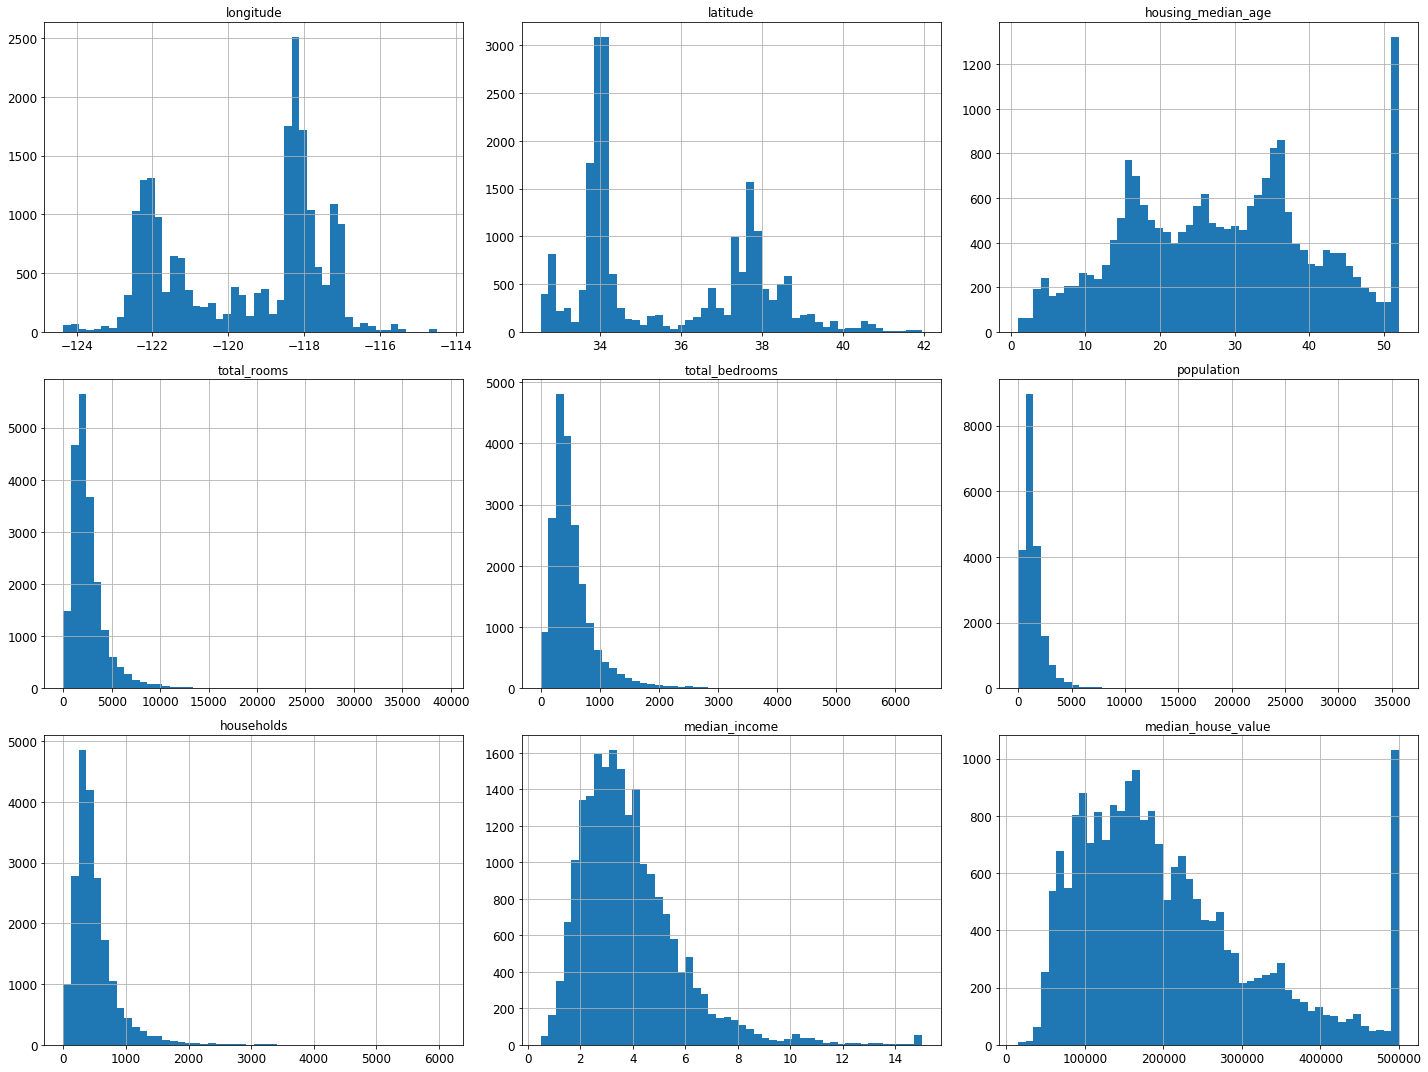

In [51]:
%matplotlib inline
#df_housing.hist(bins = 50, figsize = (20,15))
#plt.show()
float64attributes = [column for column in df_housing.columns.tolist() if df_housing[column].dtype != 'O']
fig, ax = plt.subplots(3,3, figsize = (20,15))

k = 0
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].hist(df_housing[float64attributes[k]], bins = 50)
        ax[i][j].set_title(float64attributes[k])
        ax[i][j].grid(b = True)
        k += 1

#ax[0].hist(df_housing['longitude'], bins = 50)
#plt.show()

plt.tight_layout()
plt.show()

<h2> Creating a Test Set </h2>

In [52]:
import numpy as np

def produce_test_train_set(data,test_ratio):
    indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [53]:
train_set, test_set = produce_test_train_set(df_housing, 0.2)

In [62]:
from zlib import crc32

def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda x: test_set_check(x,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set], in_test_set

In [60]:
housing_with_id = df_housing.reset_index()

In [61]:
housing_with_id.head()

index  longitude  latitude  housing_median_age  total_rooms  \
0      0    -122.23     37.88                41.0        880.0   
1      1    -122.22     37.86                21.0       7099.0   
2      2    -122.24     37.85                52.0       1467.0   
3      3    -122.25     37.85                52.0       1274.0   
4      4    -122.25     37.85                52.0       1627.0   

   total_bedrooms  population  households  median_income  median_house_value  \
0           129.0       322.0       126.0         8.3252            452600.0   
1          1106.0      2401.0      1138.0         8.3014            358500.0   
2           190.0       496.0       177.0         7.2574            352100.0   
3           235.0       558.0       219.0         5.6431            341300.0   
4           280.0       565.0       259.0         3.8462            342200.0   

  ocean_proximity  
0        NEAR BAY  
1        NEAR BAY  
2        NEAR BAY  
3        NEAR BAY  
4        NEAR BAY

In [63]:
train_set, test_set, test_indices = split_train_test_by_id(housing_with_id,0.2,"index")

Using the hash function method to calculate the checksum requires all row indices remain the same, and new data only gets appended. As this is impractical when rows have to be dropped, we need to make a unique ID for instance. 

In [69]:
#creating new column called "id" for each row
housing_with_id["id"] = df_housing["longitude"] * 1000 + df_housing['latitude']
train_set, test_set,_ = split_train_test_by_id(housing_with_id, 0.2, "id")

So far the methods of selecting the test set and train set have involved completely random sampling. This is fine as long as the dataset is large enough, however if it isnt, we can instroduce sampling bias. This is where the samples are not representative of the entire population. 

Hence we introduce **stratified sampling** where the population is subdivided into homogenous subgroups called strata. Depending on the size of the stratum (how many instances are in it), we sample it accordingly. 

In this case, we take the **median income** as an important attribute which will help us create homogenous subgroups that are representative of the population. 

In [72]:
df_housing.loc[(df_housing['median_income'] >= 0) 
               & (df_housing['median_income'] < 1.5), 'income_cat'] = 1
df_housing.loc[(df_housing['median_income'] >= 1.5) 
               & (df_housing['median_income'] < 3.0), 'income_cat'] = 2
df_housing.loc[(df_housing['median_income'] >= 3.0) 
               & (df_housing['median_income'] < 4.5), 'income_cat'] = 3
df_housing.loc[(df_housing['median_income'] >= 4.5) 
               & (df_housing['median_income'] < 6.0), 'income_cat'] = 4
df_housing.loc[(df_housing['median_income'] >= 6.0), 'income_cat'] = 5

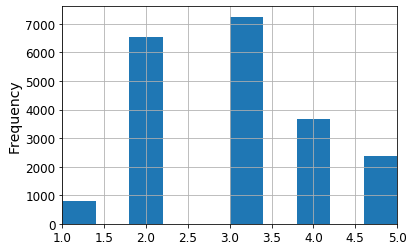

In [82]:
ax = plt.figure().add_subplot(111)
#count, bin_edges = np.histogram(df_housing['income_cat'], bins = 6)
df_housing['income_cat'].plot(kind = 'hist', ax = ax)
ax.set_xlim([1.0,5.0])
ax.grid()

As we have separated the median income into categories, we are ready to carry out stratified sampling

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

In [90]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(df_housing, df_housing['income_cat']):
    strat_train_set = df_housing.loc[train_index]
    strat_test_set = df_housing.loc[test_index]


In [92]:
strat_train_set['income_cat'].value_counts(normalize = True)

3.0    0.351260
2.0    0.317345
4.0    0.176962
5.0    0.114947
1.0    0.039486
Name: income_cat, dtype: float64

In [93]:
strat_test_set['income_cat'].value_counts(normalize = True)

3.0    0.351260
2.0    0.317345
4.0    0.176841
5.0    0.115068
1.0    0.039486
Name: income_cat, dtype: float64

In [94]:
df_housing['income_cat'].value_counts(normalize = True)

3.0    0.351260
2.0    0.317345
4.0    0.176938
5.0    0.114971
1.0    0.039486
Name: income_cat, dtype: float64

The essence of stratified sampling is to ensure that both the test set and train set be representative of the original dataset with respect to the **selected homogenous subgroups**. The above *value_counts()* shows that the proportions of each category is the same showing that the test, train and orginal data are equal in representativeness. 



In [97]:
len(df_housing[df_housing['income_cat'] == 3].index)

7250

In [99]:
len(strat_train_set[strat_train_set['income_cat'] == 3].index)

5800

In [100]:
len(strat_test_set[strat_test_set['income_cat'] == 3].index)

1450

Using normal test_train_split

In [102]:
from sklearn.model_selection  import train_test_split

train_set, test_set = train_test_split(df_housing,test_size = 0.2, random_state = 42)

In [103]:
train_set['income_cat'].value_counts(normalize = True)

3.0    0.349261
2.0    0.316013
4.0    0.179021
5.0    0.116340
1.0    0.039365
Name: income_cat, dtype: float64

In [104]:
test_set['income_cat'].value_counts(normalize = True)

3.0    0.359254
2.0    0.322674
4.0    0.168605
5.0    0.109496
1.0    0.039971
Name: income_cat, dtype: float64

In [105]:
df_housing['income_cat'].value_counts(normalize = True)

3.0    0.351260
2.0    0.317345
4.0    0.176938
5.0    0.114971
1.0    0.039486
Name: income_cat, dtype: float64

The proportions of the homogeneous stratums are not the same in the test, train and overall dataset

In [108]:
strat_train_set.drop('income_cat',axis = 1, inplace = True)
strat_test_set.drop('income_cat',axis = 1, inplace = True)

<h1> Discover Insights In The Data</h1>

In [109]:
#to not harm our initial training set when doing manipulations to it, we make a copy
housing_train = strat_train_set.copy()

In [114]:
#we shall use folium to show a visualization
import folium as fl
from folium import plugins

cali_map = fl.Map(location = [34.052235, -118.243683], zoom_start = 6)
houseclusters = plugins.MarkerCluster().add_to(cali_map)

for lng,lat in zip(housing_train.longitude,housing_train.latitude):
    fl.Marker(location = [lat,lng]).add_to(houseclusters)
cali_map